In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 

import sys
import os
import math

import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import healpy as hp
import pymaster as nmt
import pyccl as ccl

sys.path.append('..')
from experiment import Experiment, show_mcmc_report
from plotting import my_mollview, plot_correlation

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
sns.set(style='ticks')
pd.set_option('mode.chained_assignment', None)

# Parameters

In [4]:
with open('../configs.yml', 'r') as config_file:
    config = yaml.full_load(config_file)
config = config['NVSS']
display(config)

{'lss_survey': 'NVSS',
 'nside': 512,
 'bias': 2.18,
 'scale_bias': False,
 'cosmology_name': 'planck',
 'cosmology_matter_power_spectrum': 'halofit',
 'correlation_symbols': ['gg', 'gt'],
 'l_min': {'gg': 10, 'gt': 4},
 'ell_lengths': {'gg': [8, 14, 26], 'gt': [6, 12, 24, 52]},
 'starting_params': {'bias': '(2.18', '0.5)': None},
 'n_walkers': 32,
 'max_iterations': 5000,
 'continue_sampling': False}

# Data

In [5]:
experiment = Experiment(config, set_maps=True)

/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 512
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format

/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 40.767446 arcmin (0.011859 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 96.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


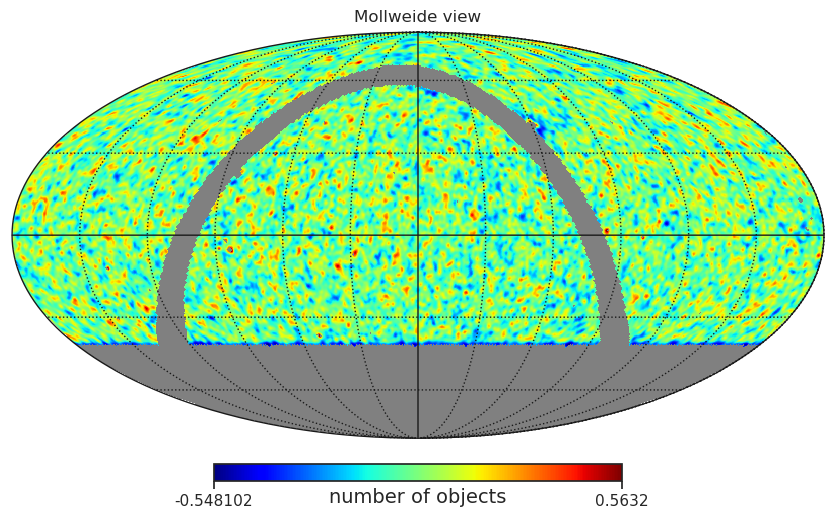

In [18]:
my_mollview(experiment.processed_maps['g'], unit='number of objects', fwhm=1.6)

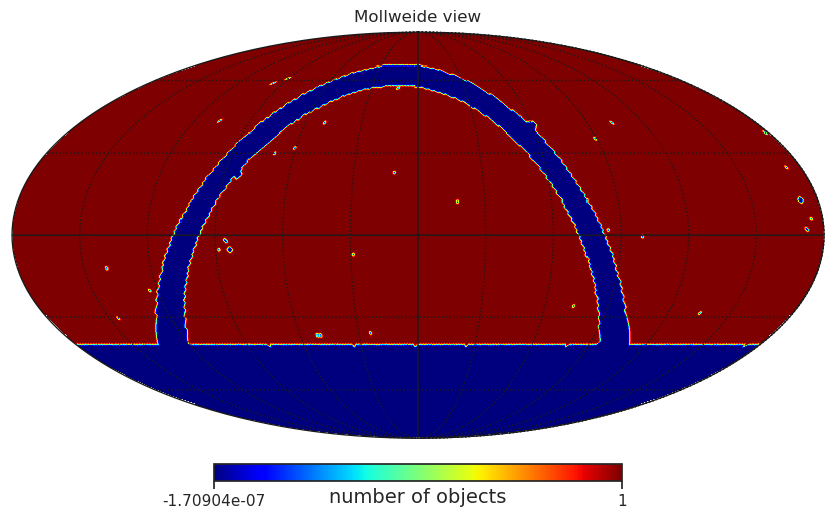

In [12]:
my_mollview(experiment.masks['g'], unit='number of objects', fwhm=0.6)

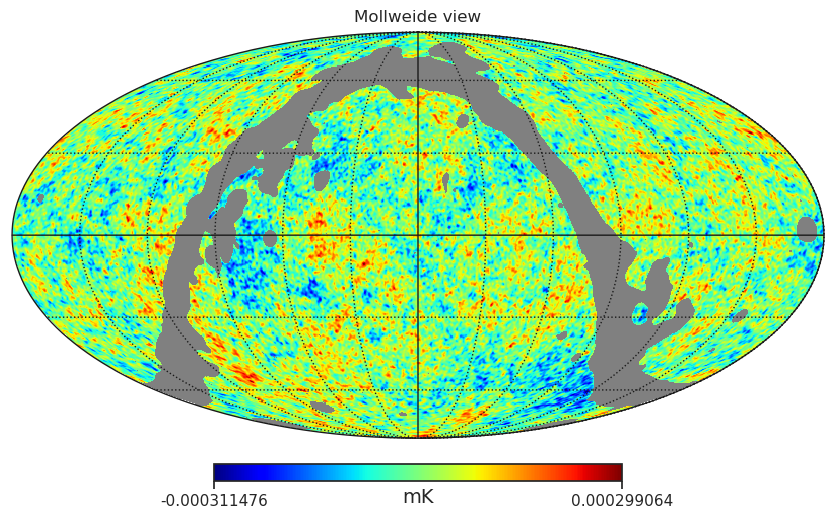

In [20]:
my_mollview(experiment.processed_maps['t'], unit='mK', fwhm=0.8)

/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 15.287792 arcmin (0.004447 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 36.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/projaxes.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and wil

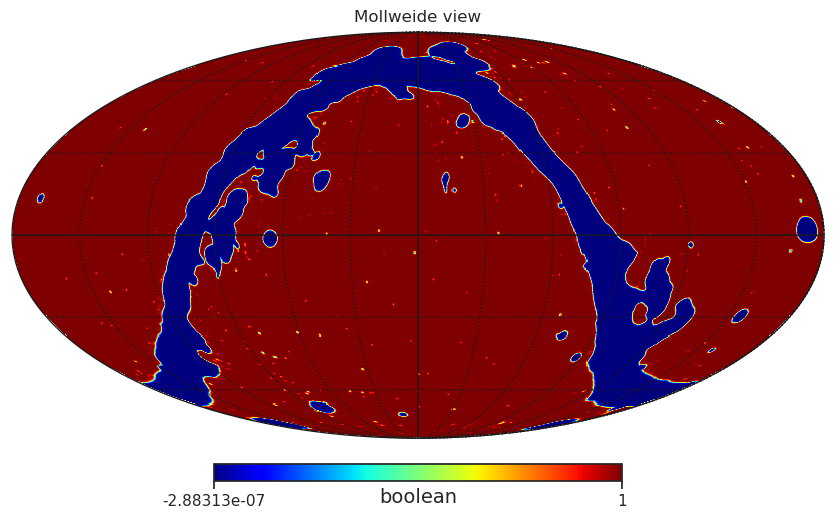

In [11]:
my_mollview(experiment.masks['t'], unit='boolean', fwhm=0.6)

# Power spectra

In [6]:
experiment.set_correlations()

In [7]:
experiment.chi_squared

{'gg': 23.292052328867292, 'gt': 1846.0225741011172}

In [8]:
experiment.sigmas

{'gg': 38.41310774089639, 'gt': 45.444966688363166}

(0.0765460427498687, 0.6539070167786581)

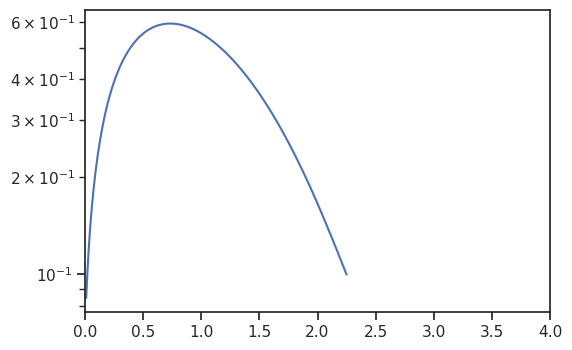

In [9]:
plt.plot(experiment.z_arr, experiment.n_arr / 19.084)
plt.yscale('log')
plt.xscale('linear')
plt.xlim(xmin=0, xmax=4)
plt.ylim(ymin=None, ymax=None)

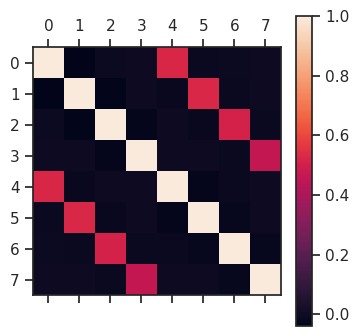

In [10]:
plt.matshow(experiment.inference_correlation)
plt.colorbar()

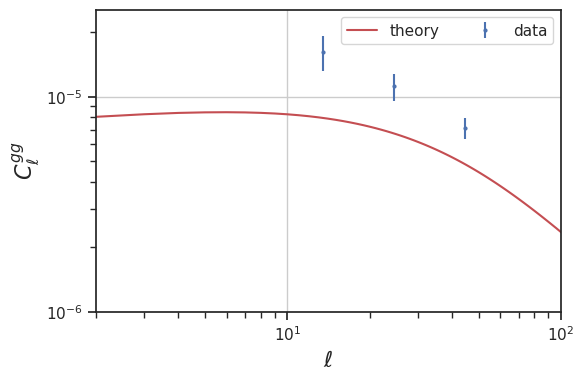

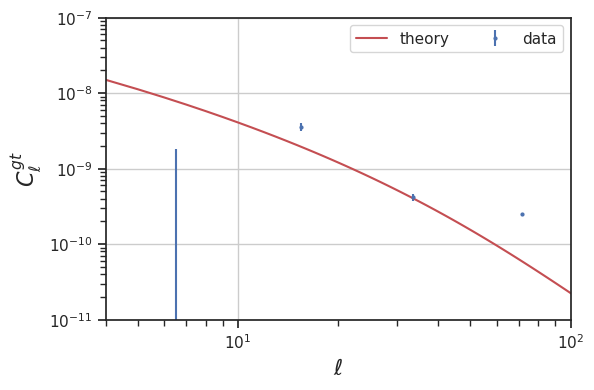

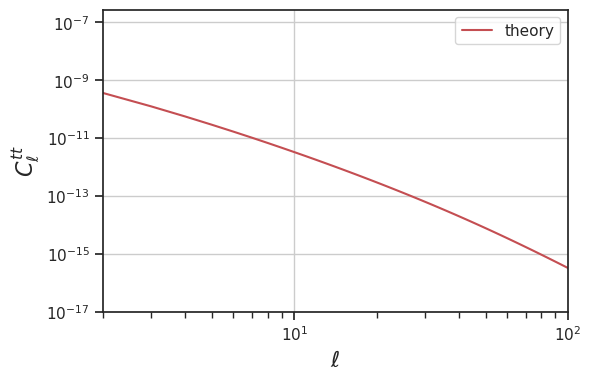

In [10]:
plot_correlation(experiment, 'gg', x_min=2, x_max=100, y_min=1e-6, y_max=None, x_scale='log', y_scale='log')
plot_correlation(experiment, 'gt', x_min=4, x_max=100, y_min=1e-11, y_max=1e-7, x_scale='log', y_scale='log')
plot_correlation(experiment, 'tt', x_min=2, x_max=100, y_min=1e-17, y_max=None, x_scale='log', y_scale='log')